Run following command to install deps:

```pip install keras-rl2 gym```

If you are interested dig deeper:
- Read what [deepmind](https://deepmind.com/blog/article/deep-reinforcement-learning) is doing.
- Read what [openAI](https://openai.com/) is doing.
- Watch [AlphaGO](https://www.imdb.com/title/tt6700846/) movie and read [paper](https://www.nature.com/articles/nature16961).
- Work through [Deep RL](https://github.com/trokas/Deep_RL), which contains more examples and intuitive lower level implementations. This [medium](https://medium.com/@awjuliani/super-simple-reinforcement-learning-tutorial-part-2-ded33892c724) series is great.
- Read book "Deep Reinforcement Learning Hands-On" by Maxim Laptan.

In [34]:
import gym
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

from scipy.stats import beta

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

import matplotlib.pyplot as plt

# Bandits

First we need an experiment, for example let's set up 3 arm bandit so that first hand gives highest reward.

In [52]:
BANDITS = [0.7, 0.2, 0.3]  # arm 1 wins with prob of 50%

def pull(i):
    return 1 if np.random.rand() < BANDITS[i] else 0

Now we can implement multi-armed bandit algorithm based on bayesian update

$$P(\theta | x)=\frac{P(x | \theta) P(\theta)}{P(x)}.$$

In [53]:
pulls = [0 for _ in range(len(BANDITS))]  # How much pulls were executed
wins =  [0 for _ in range(len(BANDITS))]  # Number of wins

n = 20    # Number of pulls to do

for _ in range(n):
    priors = [beta(1 + w, 1 + p - w) for p, w in zip(pulls, wins)]
    # Choose a 'best' bandit based on probabilities
    chosen_arm = np.argmax([p.rvs(1) for p in priors])
    # Pull and record to output
    reward = pull(chosen_arm)
    pulls[chosen_arm] += 1
    wins[chosen_arm] += reward
    
print('Total pulls', pulls)
print('Total wins ', wins)

Total pulls [17, 1, 2]
Total wins  [14, 0, 0]


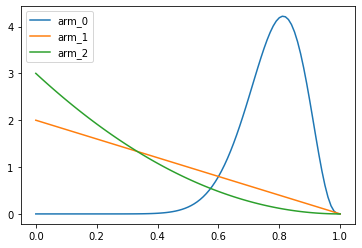

In [54]:
df = pd.DataFrame(index=np.linspace(0, 1, 101))
for i, p in enumerate(priors):
    df[f'arm_{i}'] = p.pdf(df.index)

df.plot()
plt.show()

**TASK:** rerun with higher number of experiments. Do the distributions look better then?

Usually only to exploit the system is not a good idea and *epsilon-greedy* can help to balance out explore/exploit.

Idea of *epsilon-greedy* is simple:

```python
if random_number < epsilon:
    # choose arm to pull randomly
else:
    # choose optimal arm based on pulls and wins
```

**TASK:** implement epsilon-greedy and run some experiments with different epsilon values. Try to reson when epsilon-greedy might be a better choice.

# Q-Learning

Q-learning is a model-free RL algorithm to learn quality of actions telling an agent what action to take under what circumstances. Idea is simple - we will store values in state/action table and use it as a reference for making actions.

Let's start by looking at markov decision process based game:

<img src="img/markov_decision_process.png" alt="Markov decision process" style="width: 600px;"/>

This can be represented with transition weights as follows:

In [3]:
transition_probabilities = [ # shape=[s, a, s']
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None]]
rewards = [ # shape=[s, a, s']
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]

Now we will try to run through iterative optimization process

$$Q_{k+1} (s,a) \leftarrow \sum_{s'} T(s,a,s') [R(s,a,s') + \gamma \max_{a'} Q_k(s', a')] \; \text{for all} \; (s'a).$$

In [4]:
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions
    
gamma = 0.90 # the discount factor

for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

In [5]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

The idea of using discounted rewards in Q-states is one of the fundamental ideas in RL. For sure we don't know initial probabilities and rewards, but as we will see we can learn them.

# Cartpole and DQN

Get the environment and extract the number of actions.

We will try to balance a stick - [CartPole](https://github.com/openai/gym/wiki/CartPole-v0)

![](https://miro.medium.com/max/960/1*G_whtIrY9fGlw3It6HFfhA.gif)

To meet provide this challenge we are going to utilize the [OpenAI gym](https://gym.openai.com/docs/), a collection of reinforcement learning environments.

- Observations — The agent needs to know where pole currently is, and the angle at which it is balancing.
- Delayed reward — Keeping the pole in the air as long as possible means moving in ways that will be advantageous for both the present and the future.

In [6]:
env = gym.make('CartPole-v0')
nb_actions = env.action_space.n
print('Number of actions', nb_actions)

Number of actions 2


Let's build a simple NN model.

In [7]:
model = Sequential()
model.add(Flatten(input_shape=(1, 4)))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(nb_actions))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4)                 0         
_________________________________________________________________
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 658
Trainable params: 658
Non-trainable params: 0
_________________________________________________________________


Finally, we configure and compile our agent. We will use Epsilon Greedy:
- All actions initially are tried with non-zero probability
- With probability $1-\epsilon$ choose the greedy action
- With probability $\epsilon$ choose an action ar random

and we will estimate target Q-Value using reward and the future discounted value estimate

$$Q_{target}(s,a) = r + \gamma \cdot \max_{a'} Q_\theta (s', a').$$

In [8]:
policy = EpsGreedyQPolicy()
memory = SequentialMemory(limit=50000, window_length=1)
dqn = DQNAgent(model=model, nb_actions=nb_actions,
               memory=memory, nb_steps_warmup=10, 
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

Let's see how it looks like before training. Note, that pole does not have to fall fully for gym to note it as a failed play.

In [9]:
dqn.test(env, nb_episodes=5, visualize=True)

Testing for 5 episodes ...
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Episode 1: reward: 9.000, steps: 9
Episode 2: reward: 10.000, steps: 10
Episode 3: reward: 8.000, steps: 8
Episode 4: reward: 9.000, steps: 9
Episode 5: reward: 9.000, steps: 9


In [10]:
from pyglet.gl import *

Okay, now it's time to learn something! You can visualize the training by setting `visualize=True`, but this
slows down training quite a lot.

In [11]:
dqn.fit(env, nb_steps=5000, visualize=False, verbose=2)

Training for 5000 steps ...


/Users/trokas/.local/share/virtualenvs/current-rcFo7dEP/lib/python3.7/site-packages/rl/memory.py:40: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


   12/5000: episode: 1, duration: 0.519s, episode steps:  12, steps per second:  23, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.917 [0.000, 1.000],  loss: 0.470474, mae: 0.588689, mean_q: -0.165078
   22/5000: episode: 2, duration: 0.061s, episode steps:  10, steps per second: 164, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 1.000 [1.000, 1.000],  loss: 0.430313, mae: 0.540784, mean_q: -0.092450
   31/5000: episode: 3, duration: 0.070s, episode steps:   9, steps per second: 129, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 1.000 [1.000, 1.000],  loss: 0.335967, mae: 0.472474, mean_q: 0.008541


/Users/trokas/.local/share/virtualenvs/current-rcFo7dEP/lib/python3.7/site-packages/rl/memory.py:40: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')
/Users/trokas/.local/share/virtualenvs/current-rcFo7dEP/lib/python3.7/site-packages/rl/memory.py:40: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


   41/5000: episode: 4, duration: 0.081s, episode steps:  10, steps per second: 124, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 1.000 [1.000, 1.000],  loss: 0.275959, mae: 0.449669, mean_q: 0.118187
   51/5000: episode: 5, duration: 0.092s, episode steps:  10, steps per second: 108, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 1.000 [1.000, 1.000],  loss: 0.222271, mae: 0.432547, mean_q: 0.234795
   59/5000: episode: 6, duration: 0.051s, episode steps:   8, steps per second: 156, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 1.000 [1.000, 1.000],  loss: 0.174522, mae: 0.418035, mean_q: 0.355626
   69/5000: episode: 7, duration: 0.060s, episode steps:  10, steps per second: 167, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 1.000 [1.000, 1.000],  loss: 0.141265, mae: 0.404698, mean_q: 0.483447
   79/5000: episode: 8, duration: 0.071s, episode steps:  10, steps per seco

  411/5000: episode: 41, duration: 0.082s, episode steps:  11, steps per second: 135, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 1.000 [1.000, 1.000],  loss: 0.020045, mae: 1.381140, mean_q: 2.797448
  420/5000: episode: 42, duration: 0.053s, episode steps:   9, steps per second: 170, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 1.000 [1.000, 1.000],  loss: 0.019161, mae: 1.413261, mean_q: 2.860299
  429/5000: episode: 43, duration: 0.051s, episode steps:   9, steps per second: 178, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.018604, mae: 1.456374, mean_q: 2.892892
  439/5000: episode: 44, duration: 0.056s, episode steps:  10, steps per second: 178, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.020485, mae: 1.566899, mean_q: 3.080875
  450/5000: episode: 45, duration: 0.069s, episode steps:  11, steps per

  978/5000: episode: 77, duration: 0.209s, episode steps:  36, steps per second: 172, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.000],  loss: 0.431317, mae: 3.425709, mean_q: 6.535269
 1027/5000: episode: 78, duration: 0.265s, episode steps:  49, steps per second: 185, episode reward: 49.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.612 [0.000, 1.000],  loss: 0.423559, mae: 3.513860, mean_q: 6.769080
 1059/5000: episode: 79, duration: 0.181s, episode steps:  32, steps per second: 177, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.562 [0.000, 1.000],  loss: 0.658946, mae: 3.776556, mean_q: 7.246701
 1070/5000: episode: 80, duration: 0.083s, episode steps:  11, steps per second: 132, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 0.327387, mae: 3.787353, mean_q: 7.344775
 1088/5000: episode: 81, duration: 0.115s, episode steps:  18, steps per

 4354/5000: episode: 113, duration: 0.721s, episode steps: 133, steps per second: 184, episode reward: 133.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.549 [0.000, 1.000],  loss: 2.111134, mae: 15.772705, mean_q: 32.011673
 4498/5000: episode: 114, duration: 0.878s, episode steps: 144, steps per second: 164, episode reward: 144.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.542 [0.000, 1.000],  loss: 2.185027, mae: 16.169411, mean_q: 32.845894
 4643/5000: episode: 115, duration: 0.847s, episode steps: 145, steps per second: 171, episode reward: 145.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.000],  loss: 2.088379, mae: 16.734930, mean_q: 33.954765
 4775/5000: episode: 116, duration: 0.753s, episode steps: 132, steps per second: 175, episode reward: 132.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.000],  loss: 2.871243, mae: 17.063446, mean_q: 34.656677
 4941/5000: episode: 117, duration: 0.941s, episode step

Let's test our reinforcement learning model.

In [12]:
dqn.test(env, nb_episodes=5, visualize=True)

Testing for 5 episodes ...
Episode 1: reward: 157.000, steps: 157
Episode 2: reward: 140.000, steps: 140
Episode 3: reward: 134.000, steps: 134
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 143.000, steps: 143


This is nearly a perfect play, since CartPole exits if 200 steps are reached. You can experiment with version which limit is 500 by changing env to `CartPole-v1`.

# MuZero

Recent and impressive advancement in AI is MuZero. We will just run the implementation listed in - https://github.com/werner-duvaud/muzero-general. General idea involves first constructing the embedding and only then training the agent. According to George Hotz this algorithm is the one of the most important event in the history AI that people will cite for ages.

<img width="60%" src="https://miro.medium.com/max/2424/1*NowOwxV5SQ9aLKbjdz41lQ.png"/>

In [9]:
# I just downloaded it from git and installed deps
import os
os.chdir('/Users/trokas/muzero-general/')

from muzero import MuZero

muzero = MuZero("cartpole")  # it uses v1 by default
muzero.train()

2020-12-11 14:57:51,604	ERROR worker.py:660 -- Calling ray.init() again after it has already been called.



Training...
Run tensorboard --logdir ./results and go to http://localhost:6006/ to see in real time the training performance.

(pid=33338) You are not training on GPU.
(pid=33338) 
Last test reward: 386.00. Training step: 10000/10000. Played games: 68. Loss: 5.89
Shutting down workers...


Persisting replay buffer games to disk...


Only with 68 it achieved decent result!

If you want interesting challenge you could try to add additional experiment and insted of using cartpole position as input pass image of the cartpole instead. That's where the power of MuZero can be seen, it should be able to construct internal representation suitable for learning on it's own!